### Импорт библиотек

In [1]:
import tarfile
import json 
from typing import List
from functools import partial
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import pairwise_distances

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import ADASYN

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score,  mean_squared_error, adjusted_rand_score
from sklearn.metrics import make_scorer

### Загрузка данных

In [2]:
#Распаковка архива
zipfile = 'hackathon_files_for_participants_ozon.tar.gz'
tar = tarfile.open(zipfile,"r:gz")
tar.extractall()
tar.close()

In [3]:
#Загрузка данных
df_train = pd.read_parquet('hackathon_files_for_participants_ozon/train_data.parquet', engine='pyarrow').reset_index(drop=True)
df_test = pd.read_parquet('hackathon_files_for_participants_ozon/test_data.parquet', engine='pyarrow').reset_index(drop=True)
df_train_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/train_pairs.parquet', engine='pyarrow').reset_index(drop=True)
df_test_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet', engine='pyarrow').reset_index(drop=True)

In [4]:
#Категории по уровням
df_train = df_train.join(pd.json_normalize(df_train.categories.apply(json.loads)))
df_test = df_test.join(pd.json_normalize(df_test.categories.apply(json.loads)))

In [5]:
df_train.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )
df_test.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )

In [6]:
df_train.shape

(457063, 12)

In [7]:
cat3_counts = df_train.cat3.value_counts().to_dict()
cat3_counts

{'Смартфоны, планшеты, мобильные телефоны': 59389,
 'Компьютер': 57572,
 'Чехол': 40775,
 'Расходник для печати': 38878,
 'Кабели и переходники': 26669,
 'Наушники и гарнитуры': 16944,
 'Смарт-часы': 14811,
 'Устройство ручного ввода': 14235,
 'Батарейки и аккумуляторы': 12548,
 'Зарядные устройства и док-станции': 12014,
 'Запчасти для ноутбуков': 11791,
 'Запчасти для смартфонов': 10716,
 'Жесткие диски, SSD и сетевые накопители': 10221,
 'Материнская плата': 9895,
 'Видеонаблюдение': 9791,
 'Защитные пленки и стекла': 9225,
 'Оптические приборы': 5874,
 'Карты памяти и флешки': 5741,
 'Телевизоры': 5504,
 'Игровая приставка': 5300,
 'Акустика и колонки': 5287,
 'Электронные модули': 5144,
 'Сетевое оборудование': 5026,
 'Видеокарты и графические ускорители': 4578,
 'Мониторы и запчасти': 4361,
 'Оперативная память': 3877,
 'Сетевые фильтры, разветвители и удлинители': 3658,
 'Принтеры и МФУ': 3643,
 'Аксессуары для фото и видеотехники': 2905,
 'Кронштейн': 2650,
 'Видеорегистратор':

In [8]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1000:
        cntr += cat3_counts[cat3]
        
cntr

11296

In [9]:
df_train['cat3_grouped'] = df_train.cat3.apply(lambda x: x if cat3_counts[x] > 1000 else 'rest')

### Предобработка данных

In [10]:
merged = df_train_pairs.merge(df_train.add_suffix('1'), on = 'variantid1', how = 'left')
train = merged.merge(df_train.add_suffix('2'), on = 'variantid2', how = 'left')

In [11]:
merged = df_test_pairs.merge(df_test.add_suffix('1'), on = 'variantid1', how = 'left')
test = merged.merge(df_test.add_suffix('2'), on = 'variantid2', how = 'left')

In [12]:
#Косинусное расстояние (картинки)
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):      
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(main_pic_embeddings_1, main_pic_embeddings_2)
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features




In [13]:
#Косинусное сходство (текст)
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt') # if necessary...
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))
vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words=['english','russian'])
def cosine_sim(text1, text2):
    try:
        tfidf = vectorizer.fit_transform([text1, text2])
        cos_sim = ((tfidf * tfidf.T).A)[0,1]
    except: 
        cos_sim = 0
    return cos_sim

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tamar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
#Заполним пропуски
train.characteristic_attributes_mapping1.fillna('{}', inplace=True)
train.characteristic_attributes_mapping2.fillna('{}', inplace=True)
test.characteristic_attributes_mapping1.fillna('{}', inplace=True)
test.characteristic_attributes_mapping2.fillna('{}', inplace=True)

In [15]:
#Оставим только совпадающие характеристики
def attr(attributes1, attributes2):
    dict1 = json.loads(attributes1)
    dict2 = json.loads(attributes2)
    common_keys = set(dict1.keys()) & set(dict2.keys())
    new_dict1 = {key: dict1[key] for key in common_keys}
    new_dict2 = {key: dict2[key] for key in common_keys}
    attributes1 = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict1.items())
    attributes2 = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict2.items())
    return attributes1, attributes2

In [16]:
train[['attributes1', 'attributes2']] = (
    train[['characteristic_attributes_mapping1', 'characteristic_attributes_mapping2']].apply(
        lambda x: pd.Series(attr(*x)), axis=1))
test[['attributes1', 'attributes2']] = (
    test[['characteristic_attributes_mapping1', 'characteristic_attributes_mapping2']].apply(
        lambda x: pd.Series(attr(*x)), axis=1))

C:\Users\tamar\AppData\Local\Temp\ipykernel_1720\2695762742.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.attributes1[i] = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict1.items())
C:\Users\tamar\AppData\Local\Temp\ipykernel_1720\2695762742.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.attributes2[i] = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict2.items())
C:\Users\tamar\AppData\Local\Temp\ipykernel_1720\2695762742.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

In [19]:
get_pic_features_func = partial(get_pic_features,percentiles=[0, 25, 50])

In [20]:
train[['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc']] = (
    train[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))
train[['pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc']] = (
    train[['pic_embeddings_resnet_v11', 'pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))

In [21]:
train['cosine_name_sim'] = (
    train[['name1', 'name2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))
train['cosine_attr_sim'] = (
    train[['attributes1', 'attributes2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [22]:
test[['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc']] = (
    test[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))
test[['pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc']] = (
    test[['pic_embeddings_resnet_v11', 'pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))

In [23]:
test['cosine_name_sim'] = (
    test[['name1', 'name2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))
test['cosine_attr_sim'] = (
    test[['attributes1', 'attributes2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [24]:
feats = ['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc', 'pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc', 
         'cosine_name_sim', 'cosine_attr_sim']

In [25]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

In [26]:
def all_metrics(y_true, y_pred, y_pred_proba, y_test, X_test):
    dict_metric = {}
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 1) & (y_pred == 0))
    FN = np.sum((y_true == 0) & (y_pred == 1))
    
    pr_auc_macro_metr = pr_auc_macro(
            target_df=pd.DataFrame(y_test), 
            predictions_df=X_test,
            prec_level=0.75,
            cat_column='cat3_grouped1'
            )

    dict_metric['P'] = [P, 'ЕСТЬ совпадение товаров']
    dict_metric['N'] = [N, 'НЕТ совпадения товаров ']
    dict_metric['TP'] = [TP, 'Истинно совпавшие']
    dict_metric['TN'] = [TN, 'Истинно не-совпавшие']
    dict_metric['FP'] = [FP, 'Ложно совпавшие']
    dict_metric['FN'] = [FN, 'Ложно не-совпавшие']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred), 'Доля верно определённых']
    dict_metric['Precision'] = [precision_score(y_true, y_pred), 'Точность определения']
    dict_metric['Recall'] = [recall_score(y_true, y_pred), 'Полнота определения']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_proba), 'ROC-AUC']
    dict_metric['AUPRC'] = [average_precision_score(y_true, y_pred_proba), 'AUPRC']
    dict_metric['pr_auc_macro_metr'] = [pr_auc_macro_metr, 'pr_auc_macro_metr']

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df)

In [27]:
X_train, X_test = train_test_split(train[feats + ['target', 'variantid1', 'variantid2', 'cat3_grouped1']], 
    test_size=0.2, random_state=42, stratify=train[['target', 'cat3_grouped1']])

X_train, X_val = train_test_split(X_train[feats + ['target', 'variantid1', 'variantid2', 'cat3_grouped1']], 
    test_size=0.2, random_state=42, stratify=X_train[['target', 'cat3_grouped1']])

y_test = X_test[['target', 'variantid1', 'variantid2']]
X_test = X_test.drop(['target'], axis=1)

y_train = X_train['target']
y_val = X_val['target']

X_train = X_train.drop(['target'], axis=1)
X_val = X_val.drop(['target'], axis=1)


train_pool = Pool(data=X_train[feats], label=y_train)
eval_pool = Pool(data=X_val[feats], label=y_val)

In [28]:
estimators = [('ets', ExtraTreesClassifier()),
              ('et', ExtraTreeClassifier()),
              ('dt', DecisionTreeClassifier()),
              ('rf', RandomForestClassifier()),
              ('knn', KNeighborsClassifier()),
              ('mlp', MLPClassifier()),
              ('bc', BaggingClassifier()),
              ('gbc', GradientBoostingClassifier()),
              ('cat', CatBoostClassifier()),
             ('ada', AdaBoostClassifier())]
model = VotingClassifier(estimators=estimators, voting='soft', weights=[1,1,1,1,1,1,1,2,2,2], flatten_transform=True)

model.fit(X_train[feats], y_train.values)

y_pred_proba = model.predict_proba(X_test[feats])[:, 1]
y_pred = model.predict(X_test[feats])
X_test['scores'] = model.predict_proba(X_test[feats])[:, 1]
all_metrics(y_test.target, y_pred, y_pred_proba, y_test, X_test)

Learning rate set to 0.098153
0:	learn: 0.6734265	total: 278ms	remaining: 4m 37s
1:	learn: 0.6580695	total: 334ms	remaining: 2m 46s
2:	learn: 0.6455439	total: 369ms	remaining: 2m 2s
3:	learn: 0.6342814	total: 398ms	remaining: 1m 38s
4:	learn: 0.6247819	total: 422ms	remaining: 1m 24s
5:	learn: 0.6172677	total: 442ms	remaining: 1m 13s
6:	learn: 0.6108691	total: 460ms	remaining: 1m 5s
7:	learn: 0.6058323	total: 475ms	remaining: 58.9s
8:	learn: 0.6016758	total: 492ms	remaining: 54.1s
9:	learn: 0.5976000	total: 508ms	remaining: 50.2s
10:	learn: 0.5946795	total: 523ms	remaining: 47s
11:	learn: 0.5919746	total: 541ms	remaining: 44.5s
12:	learn: 0.5896410	total: 557ms	remaining: 42.3s
13:	learn: 0.5870159	total: 572ms	remaining: 40.3s
14:	learn: 0.5847462	total: 588ms	remaining: 38.6s
15:	learn: 0.5832426	total: 604ms	remaining: 37.1s
16:	learn: 0.5813643	total: 620ms	remaining: 35.8s
17:	learn: 0.5798707	total: 635ms	remaining: 34.6s
18:	learn: 0.5788032	total: 651ms	remaining: 33.6s
19:	lear

163:	learn: 0.5306352	total: 3.05s	remaining: 15.6s
164:	learn: 0.5305162	total: 3.07s	remaining: 15.6s
165:	learn: 0.5303110	total: 3.09s	remaining: 15.5s
166:	learn: 0.5301137	total: 3.11s	remaining: 15.5s
167:	learn: 0.5299416	total: 3.12s	remaining: 15.5s
168:	learn: 0.5298486	total: 3.14s	remaining: 15.4s
169:	learn: 0.5296572	total: 3.15s	remaining: 15.4s
170:	learn: 0.5295912	total: 3.17s	remaining: 15.4s
171:	learn: 0.5294691	total: 3.19s	remaining: 15.3s
172:	learn: 0.5293273	total: 3.2s	remaining: 15.3s
173:	learn: 0.5292456	total: 3.22s	remaining: 15.3s
174:	learn: 0.5290990	total: 3.23s	remaining: 15.2s
175:	learn: 0.5289651	total: 3.25s	remaining: 15.2s
176:	learn: 0.5288127	total: 3.27s	remaining: 15.2s
177:	learn: 0.5286390	total: 3.28s	remaining: 15.2s
178:	learn: 0.5285180	total: 3.3s	remaining: 15.1s
179:	learn: 0.5284445	total: 3.32s	remaining: 15.1s
180:	learn: 0.5283816	total: 3.33s	remaining: 15.1s
181:	learn: 0.5281323	total: 3.35s	remaining: 15.1s
182:	learn: 0.

330:	learn: 0.5134995	total: 5.83s	remaining: 11.8s
331:	learn: 0.5134139	total: 5.85s	remaining: 11.8s
332:	learn: 0.5133537	total: 5.87s	remaining: 11.8s
333:	learn: 0.5132852	total: 5.88s	remaining: 11.7s
334:	learn: 0.5132432	total: 5.9s	remaining: 11.7s
335:	learn: 0.5131945	total: 5.91s	remaining: 11.7s
336:	learn: 0.5131121	total: 5.93s	remaining: 11.7s
337:	learn: 0.5130388	total: 5.94s	remaining: 11.6s
338:	learn: 0.5129632	total: 5.96s	remaining: 11.6s
339:	learn: 0.5129120	total: 5.98s	remaining: 11.6s
340:	learn: 0.5128624	total: 5.99s	remaining: 11.6s
341:	learn: 0.5127440	total: 6.01s	remaining: 11.6s
342:	learn: 0.5126816	total: 6.03s	remaining: 11.5s
343:	learn: 0.5126082	total: 6.05s	remaining: 11.5s
344:	learn: 0.5125269	total: 6.06s	remaining: 11.5s
345:	learn: 0.5124773	total: 6.08s	remaining: 11.5s
346:	learn: 0.5124056	total: 6.1s	remaining: 11.5s
347:	learn: 0.5123536	total: 6.11s	remaining: 11.5s
348:	learn: 0.5123103	total: 6.13s	remaining: 11.4s
349:	learn: 0.

495:	learn: 0.5042509	total: 8.58s	remaining: 8.72s
496:	learn: 0.5042036	total: 8.61s	remaining: 8.71s
497:	learn: 0.5041613	total: 8.62s	remaining: 8.69s
498:	learn: 0.5041087	total: 8.64s	remaining: 8.67s
499:	learn: 0.5040784	total: 8.66s	remaining: 8.66s
500:	learn: 0.5040443	total: 8.67s	remaining: 8.64s
501:	learn: 0.5039502	total: 8.69s	remaining: 8.62s
502:	learn: 0.5039050	total: 8.71s	remaining: 8.61s
503:	learn: 0.5038411	total: 8.73s	remaining: 8.59s
504:	learn: 0.5037939	total: 8.74s	remaining: 8.57s
505:	learn: 0.5037517	total: 8.76s	remaining: 8.55s
506:	learn: 0.5037137	total: 8.78s	remaining: 8.54s
507:	learn: 0.5036819	total: 8.79s	remaining: 8.52s
508:	learn: 0.5036294	total: 8.82s	remaining: 8.5s
509:	learn: 0.5035917	total: 8.83s	remaining: 8.49s
510:	learn: 0.5035485	total: 8.85s	remaining: 8.47s
511:	learn: 0.5035008	total: 8.87s	remaining: 8.45s
512:	learn: 0.5034643	total: 8.88s	remaining: 8.43s
513:	learn: 0.5034325	total: 8.9s	remaining: 8.41s
514:	learn: 0.

662:	learn: 0.4969556	total: 11.4s	remaining: 5.78s
663:	learn: 0.4969224	total: 11.4s	remaining: 5.76s
664:	learn: 0.4968806	total: 11.4s	remaining: 5.75s
665:	learn: 0.4968378	total: 11.4s	remaining: 5.73s
666:	learn: 0.4967797	total: 11.4s	remaining: 5.71s
667:	learn: 0.4967501	total: 11.5s	remaining: 5.69s
668:	learn: 0.4967189	total: 11.5s	remaining: 5.67s
669:	learn: 0.4966845	total: 11.5s	remaining: 5.66s
670:	learn: 0.4966598	total: 11.5s	remaining: 5.64s
671:	learn: 0.4966206	total: 11.5s	remaining: 5.62s
672:	learn: 0.4965684	total: 11.5s	remaining: 5.6s
673:	learn: 0.4965314	total: 11.6s	remaining: 5.59s
674:	learn: 0.4964945	total: 11.6s	remaining: 5.57s
675:	learn: 0.4964504	total: 11.6s	remaining: 5.55s
676:	learn: 0.4964075	total: 11.6s	remaining: 5.54s
677:	learn: 0.4963678	total: 11.6s	remaining: 5.52s
678:	learn: 0.4963183	total: 11.6s	remaining: 5.5s
679:	learn: 0.4962736	total: 11.7s	remaining: 5.48s
680:	learn: 0.4962468	total: 11.7s	remaining: 5.47s
681:	learn: 0.

831:	learn: 0.4908517	total: 14.2s	remaining: 2.86s
832:	learn: 0.4908073	total: 14.2s	remaining: 2.84s
833:	learn: 0.4907440	total: 14.2s	remaining: 2.83s
834:	learn: 0.4907081	total: 14.2s	remaining: 2.81s
835:	learn: 0.4906788	total: 14.2s	remaining: 2.79s
836:	learn: 0.4906584	total: 14.2s	remaining: 2.77s
837:	learn: 0.4906014	total: 14.3s	remaining: 2.76s
838:	learn: 0.4905633	total: 14.3s	remaining: 2.74s
839:	learn: 0.4905226	total: 14.3s	remaining: 2.72s
840:	learn: 0.4904836	total: 14.3s	remaining: 2.71s
841:	learn: 0.4904615	total: 14.3s	remaining: 2.69s
842:	learn: 0.4904268	total: 14.3s	remaining: 2.67s
843:	learn: 0.4903869	total: 14.4s	remaining: 2.65s
844:	learn: 0.4903663	total: 14.4s	remaining: 2.64s
845:	learn: 0.4903373	total: 14.4s	remaining: 2.62s
846:	learn: 0.4903013	total: 14.4s	remaining: 2.6s
847:	learn: 0.4902682	total: 14.4s	remaining: 2.59s
848:	learn: 0.4902377	total: 14.4s	remaining: 2.57s
849:	learn: 0.4902045	total: 14.5s	remaining: 2.55s
850:	learn: 0

,Значение,Описание метрики
P,27003.000000,ЕСТЬ совпадение товаров
N,34305.000000,НЕТ совпадения товаров
TP,18408.000000,Истинно совпавшие
TN,27229.000000,Истинно не-совпавшие
FP,8595.000000,Ложно совпавшие
FN,7076.000000,Ложно не-совпавшие
Accuracy,0.744389,Доля верно определённых
Precision,0.722336,Точность определения
Recall,0.681702,Полнота определения
F1-score,0.701431,Среднее гармоническое Precision и Recall


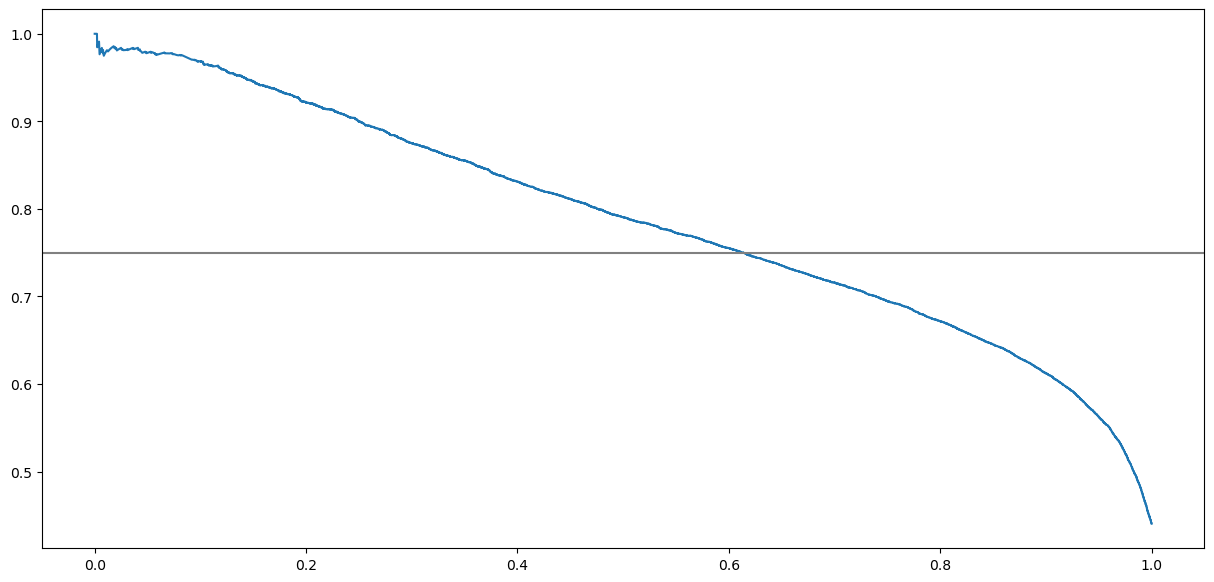

In [29]:
precision, recall, thrs = precision_recall_curve(y_test['target'], X_test['scores'])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [ ]:
import pickle
# save
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
# load
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

### Submission

In [50]:
test.shape

(18084, 35)

In [51]:
test_cat3_counts = test.cat31.value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [52]:
test['cat3_grouped'] = test.cat31.apply(lambda x: x if test_cat3_counts[x] > 50 else 'rest')

In [53]:
submission = test.copy()

In [54]:
submission['target'] = model.predict_proba(test[feats])[:, 1]

In [55]:
submission = submission[['variantid1', 'variantid2', 'cat3_grouped', 'target']]

In [57]:
submission.drop_duplicates().to_csv('submission_sc5.csv', index=False)